# Initial analysis of CROCO IPBW simulation

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram

In [2]:
client = Client(n_workers=16)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 16
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35165,Workers: 16
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:41835,Total threads: 1
Dashboard: /proxy/42845/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:37681,


## Load data files and add some extra information (e.g. binning)

In [4]:
# files:
# base = '/g/data/e14/rmh561/croco/archive/IPBW/';
base = '/g/data/e14/rmh561/croco/archive/PBW/';
favg = xr.open_dataset(base + 'croco_avg_02.nc').chunk({'time': 1})

# Generate xgcm grid object:
grid = Grid(favg,coords={"xi":{"center":"xi_rho","inner":"xi_u"},
                         "eta":{"center":"eta_rho","inner":"eta_v"},
                         "s":{"center":"s_rho","outer":"s_w"}},periodic=False)

In [5]:
# Calculate total y-transport:
ty_trans = grid.interp(favg.h/favg.pm,'eta')*favg.vbar

lon = favg.lon_rho.isel(eta_rho=0)
lat = favg.lat_v.isel(xi_rho=0)
ty_trans = ty_trans.assign_coords({"lat":lat,"lon" : lon})
ty_trans.load()

<xarray.DataArray (eta_v: 428, xi_rho: 761, time: 360)>
array([[[ -165335.89  ,  -231893.1   ,  -307141.94  , ...,
          -975454.2   , -1006549.9   , -1033244.75  ],
        [   55739.71  ,    -7184.8643,   -67876.98  , ...,
          -225328.23  ,  -245557.16  ,  -261619.44  ],
        [   53460.984 ,    -5961.654 ,   -64718.605 , ...,
          -194962.1   ,  -211371.88  ,  -234354.52  ],
        ...,
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ]],

       [[ -388407.2   ,  -458959.53  ,  -549228.94  , ...,
         -1734492.2   , -1776671.2   , -1814191.6   ],
        [ -388421.56  ,  -458989.66  ,  -549263.44  , ...,
         -1734496.    , -1776674.1   , -1814208.5   ],
        [ -365551.8   ,  -417678.3   ,  -493094.5   , ...,
         -1487299.9   , -1530040.    , -1583370.4   ],
...
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ]],

       [[       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        ...,
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ],
        [       0.    ,        0.    ,        0.    , ...,
                0.    ,        0.    ,        0.    ]]], dtype=float32)
Coordinates:
  * eta_v    (eta_v) float32 1.5 2.5 3.5 4.5 5.5 ... 42.5 43.5 44.5 45.5 46.5
  * xi_rho   (xi_rho) float32 1.0 2.0 3.0 4.0 5.0 ... 40.0 41.0 42.0 43.0 44.0
    lon_v    (eta_v) float32 -260.0 -260.0 -260.0 ... -260.0 -260.0 -260.0
    lat_v    (eta_v) float32 -29.89 -29.68 -29.46 -29.24 ... 59.76 59.88 60.01
  * time     (time) float64 3.132e+07 3.175e+07 3.218e+07 ... 1.86e+08 1.864e+08
    lat      (eta_v) float32 -29.89 -29.68 -29.46 -29.24 ... 59.76 59.88 60.01
    eta_rho  float32 1.0
    lon_rho  (xi_rho) float32 -260.0 -259.8 -259.5 -259.2 ... -70.5 -70.25 -70.0
    lat_rho  (xi_rho) float32 -30.0 -30.0 -30.0 -30.0 ... -30.0 -30.0 -30.0
    lon      (xi_rho) float32 -260.0 -259.8 -259.5 -259.2 ... -70.5 -70.25 -70.0

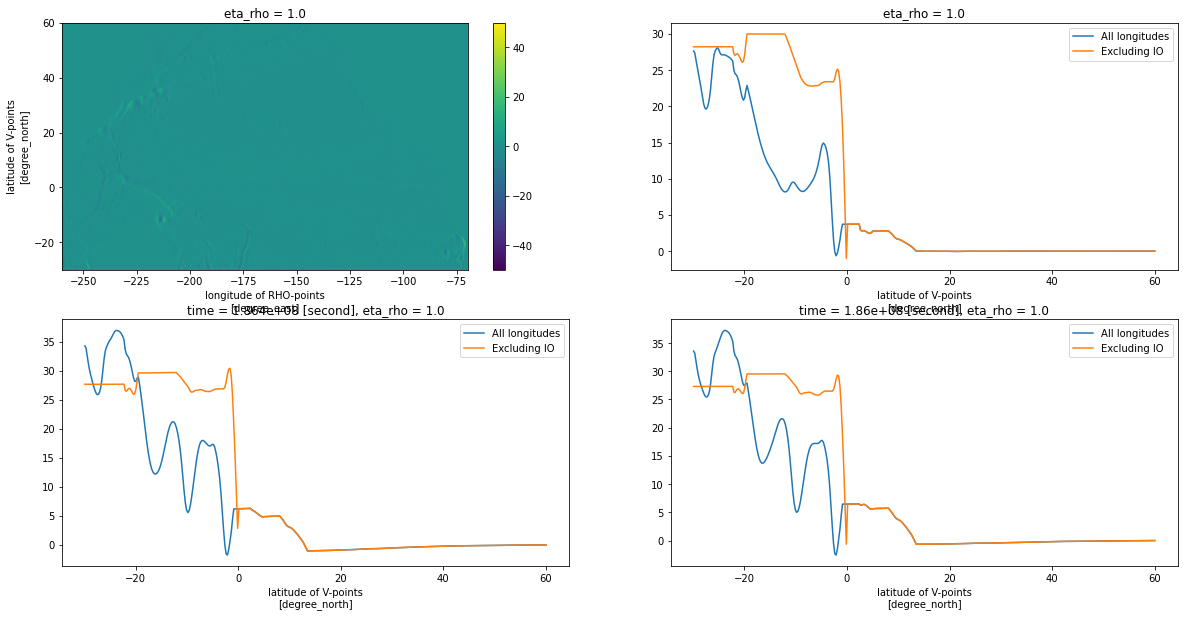

In [9]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
(ty_trans.mean('time')/1.e6).plot(x='lon',y='lat',vmin=-50.,vmax=50.)

plt.subplot(2,2,2)
(ty_trans.sum('xi_rho')/1.e6).mean('time').plot(x='lat',label='All longitudes')
(ty_trans.where(np.logical_or(favg.lon_v>-225.,favg.lat_v>0.)).sum('xi_rho')/1.e6).mean('time').plot(x='lat',label='Excluding IO')
plt.legend()

plt.subplot(2,2,3)
(ty_trans.sum('xi_rho')/1.e6).isel(time=-1).plot(x='lat',label='All longitudes')
(ty_trans.where(np.logical_or(favg.lon_v>-225.,favg.lat_v>0.)).sum('xi_rho')/1.e6).isel(time=-1).plot(x='lat',label='Excluding IO')
plt.legend()

plt.subplot(2,2,4)
(ty_trans.sum('xi_rho')/1.e6).isel(time=-2).plot(x='lat',label='All longitudes')
(ty_trans.where(np.logical_or(favg.lon_v>-225.,favg.lat_v>0.)).sum('xi_rho')/1.e6).isel(time=-2).plot(x='lat',label='Excluding IO')
plt.legend()

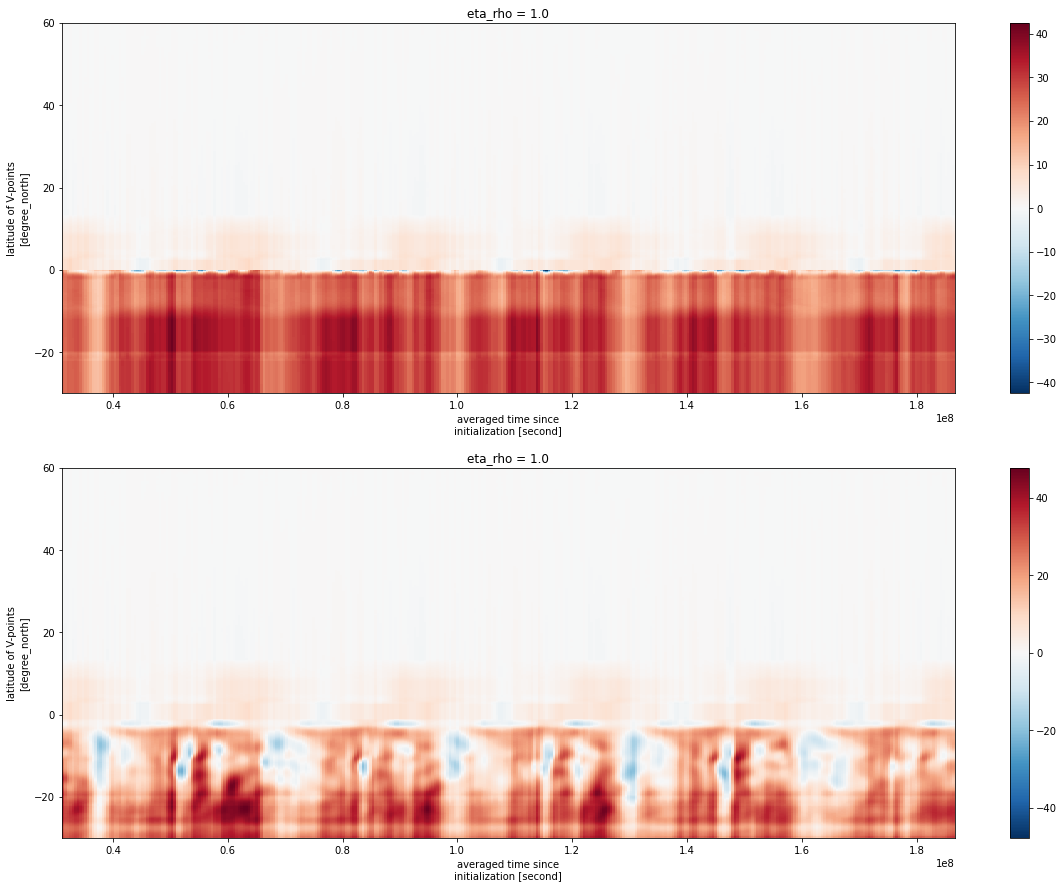

In [12]:
plt.figure(figsize=(20,15))

plt.subplot(2,1,1)
(ty_trans.where(np.logical_or(favg.lon_v>-225.,favg.lat_v>0.)).sum("xi_rho")/1.e6).plot(x='time',y='lat')

plt.subplot(2,1,2)
(ty_trans.sum("xi_rho")/1.e6).plot(x='time',y='lat')

In [4]:
#tx_trans = grid.interp(favg.h/favg.pn,'xi')*favg.ubar
ty_trans = grid.interp(favg.h/favg.pm,'eta')*favg.vbar
#tx_trans = tx_trans.isel(time=slice(50,76)).mean('time')
#ty_trans = ty_trans.isel(time=slice(50,76)).mean('time')
#BTsf = grid.cumsum(tx_trans,'eta',boundary="fill",fill_value=0.)
BTsf = grid.cumsum(ty_trans,'xi',boundary="fill",fill_value=0.)

#lon = favg.lon_u.isel(eta_rho=0)
#lat = favg.lat_v.isel(xi_rho=0)
#BTsf = BTsf.assign_coords({"lat":lat,"lon" : lon})
BTsf = BTsf.assign_coords({"lat":lat,"lon" : lon})
BTsf.load()

lon = favg.lon_rho.isel(eta_rho=0)
lat = favg.lat_v.isel(xi_rho=0)
ty_trans = ty_trans.assign_coords({"lat":lat,"lon" : lon})
ty_trans.load()

lon = favg.lon_u.isel(eta_rho=0)
lat = favg.lat_rho.isel(xi_rho=0)
tx_trans = tx_trans.assign_coords({"lat":lat,"lon" : lon})
tx_trans.load()

<xarray.DataArray (eta_rho: 429, xi_u: 760)>
array([[  270041.4 ,   439629.  ,   731315.8 , ...,        0.  ,
               0.  ,        0.  ],
       [  106262.55,   439633.62,   731322.06, ...,        0.  ,
               0.  , -5641241.5 ],
       [  127515.93,   558236.2 ,   946972.4 , ...,        0.  ,
               0.  , -5653967.5 ],
       ...,
       [       0.  ,        0.  ,        0.  , ...,        0.  ,
               0.  , -2953496.5 ],
       [       0.  ,        0.  ,        0.  , ...,        0.  ,
               0.  , -2941742.2 ],
       [       0.  ,        0.  ,        0.  , ...,        0.  ,
               0.  ,        0.  ]], dtype=float32)
Coordinates:
  * eta_rho  (eta_rho) float32 1.0 2.0 3.0 4.0 5.0 ... 42.0 43.0 44.0 45.0 46.0
  * xi_u     (xi_u) float32 1.5 2.5 3.5 4.5 5.5 6.5 ... 40.5 41.5 42.5 43.5 44.5
    lon_u    (xi_u) float32 -259.9 -259.6 -259.4 -259.1 ... -70.62 -70.38 -70.12
    lat_u    (xi_u) float32 -30.0 -30.0 -30.0 -30.0 ... -30.0 -30.0 -30.0 -30.0
    xi_rho   float32 1.0
    lon_rho  (eta_rho) float32 -260.0 -260.0 -260.0 ... -260.0 -260.0 -260.0
    lat_rho  (eta_rho) float32 -30.0 -29.78 -29.57 -29.35 ... 59.82 59.94 60.07
    lat      (eta_rho) float32 -30.0 -29.78 -29.57 -29.35 ... 59.82 59.94 60.07
    lon      (xi_u) float32 -259.9 -259.6 -259.4 -259.1 ... -70.62 -70.38 -70.12

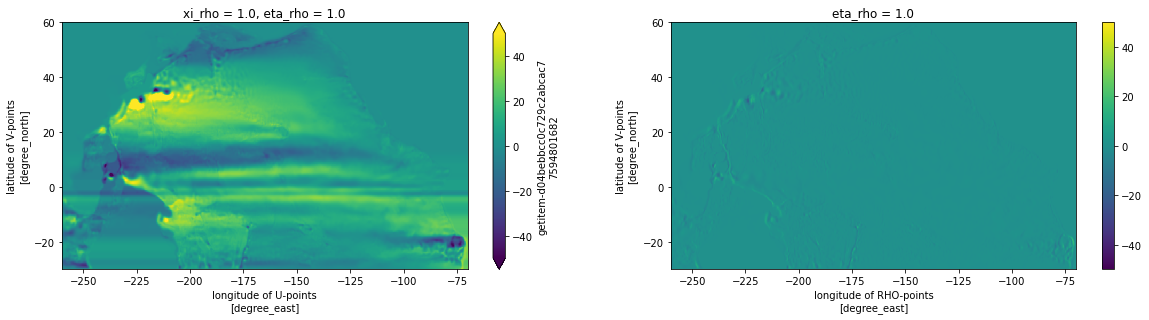

In [5]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
(BTsf/1.e6).plot(x='lon',y='lat',vmin=-50.,vmax=50.)

plt.subplot(2,2,2)
(ty_trans/1.e6).plot(x='lon',y='lat',vmin=-50.,vmax=50.)

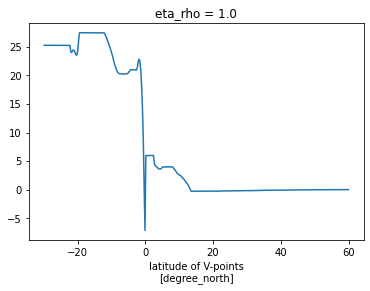

In [13]:
(ty_trans.where(np.logical_or(favg.lon_v>-225.,favg.lat_v>0.)).sum('xi_rho')/1.e6).plot(x='lat')

In [12]:
(ty_trans.where(np.logical_or(favg.lon_v>-225.,favg.lat_v>0.)).sum('xi_rho')/1.e6)

<xarray.DataArray (eta_v: 428)>
dask.array<truediv, shape=(428,), dtype=float32, chunksize=(428,), chunktype=numpy.ndarray>
Coordinates:
  * eta_v    (eta_v) float32 1.5 2.5 3.5 4.5 5.5 ... 42.5 43.5 44.5 45.5 46.5
    lat      (eta_v) float32 -29.89 -29.68 -29.46 -29.24 ... 59.76 59.88 60.01
    eta_rho  float32 1.0

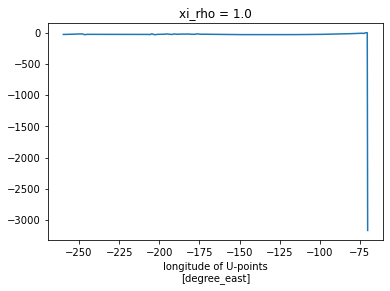

In [7]:
(tx_trans.sum('eta_rho')/1.e6).plot(x='lon')